In [1]:
%%writefile settings.py
class Settings:
    def __init__(self):
        pass

    REVIEWS_FILE = '/home/rt/wrk/w209/yelp/data/reviews.json'
    MONGO_CONNECTION_STRING = "mongodb://localhost:27017/"
    REVIEWS_DATABASE = "yelp"
    TAGS_DATABASE = "tags"
    REVIEWS_COLLECTION = "reviews"
    CORPUS_COLLECTION = "corpus"
    DATA = '/home/rt/wrk/w209/yelp/data'

Overwriting settings.py


## Sentimental Analysis of Reviews

In [2]:
%reload_ext autoreload
%autoreload 2
from settings import Settings
Settings.MONGO_CONNECTION_STRING

'mongodb://localhost:27017/'

In [17]:
import os
import time

from pymongo import MongoClient
import nltk

from settings import Settings


reviews_collection = MongoClient(Settings.MONGO_CONNECTION_STRING)[Settings.REVIEWS_DATABASE][Settings.REVIEWS_COLLECTION]
tags_collection = MongoClient(Settings.MONGO_CONNECTION_STRING)[Settings.TAGS_DATABASE][Settings.REVIEWS_COLLECTION]

reviews_cursor = reviews_collection.find({'business_id': '4bEjOyTaDG24SY5TxsaUNQ'})
reviews_count = reviews_cursor.count()
reviews_cursor.batch_size(1000)

stopwords = {}
with open('stopwords.txt', 'rU') as f:
    for line in f:
        stopwords[line.strip()] = 1

done = 0
start = time.time()

for review in reviews_cursor:
    words = []
    sentences = nltk.sent_tokenize(review["text"].lower().replace('\r\n', ' '))

    for sentence in sentences:
        tokens = nltk.word_tokenize(sentence)
        text = [word for word in tokens if word not in stopwords]
        tagged_text = nltk.pos_tag(text)

        for word, tag in tagged_text:
            words.append({"word": word, "pos": tag})
        
        #print sentence

    tags_collection.insert_many({
        "reviewId": review["review_id"],
        "business": review["business_id"],
        "text": review["text"],
        "stars": review["stars"],
        "words": words
    })

    done += 1
    if done % 100 == 0:
        end = time.time()
        os.system('cls')
        print 'Done ' + str(done) + ' out of ' + str(reviews_count) + ' in ' + str((end - start))

Done 100 out of 4137 in 6.44797301292
Done 200 out of 4137 in 14.6261591911
Done 300 out of 4137 in 22.4360771179
Done 400 out of 4137 in 30.5278820992
Done 500 out of 4137 in 38.2301311493
Done 600 out of 4137 in 46.2462801933
Done 700 out of 4137 in 53.5938122272
Done 800 out of 4137 in 59.9264461994
Done 900 out of 4137 in 66.6041970253
Done 1000 out of 4137 in 73.3279311657
Done 1100 out of 4137 in 79.9920830727
Done 1200 out of 4137 in 86.4331321716
Done 1300 out of 4137 in 92.8286862373
Done 1400 out of 4137 in 99.6583511829
Done 1500 out of 4137 in 106.010366201
Done 1600 out of 4137 in 111.845634222
Done 1700 out of 4137 in 118.660789013
Done 1800 out of 4137 in 124.495611191
Done 1900 out of 4137 in 130.535201073
Done 2000 out of 4137 in 136.727561235
Done 2100 out of 4137 in 143.076666117
Done 2200 out of 4137 in 149.159456015
Done 2300 out of 4137 in 154.988416195
Done 2400 out of 4137 in 160.120029211
Done 2500 out of 4137 in 164.8184762
Done 2600 out of 4137 in 170.1862020

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:44: DeprecationWarning: insert is deprecated. Use insert_one or insert_many instead.


In [3]:
print Settings.DATA

/home/rt/wrk/w209/yelp/data


In [4]:
import gensim
import os

LabeledSentence = gensim.models.doc2vec.LabeledSentence

from sklearn.cross_validation import train_test_split
import numpy as np

with open(os.path.join(Settings.DATA, 'positive.csv'),'r') as infile:
    pos_reviews = infile.readlines()

with open(os.path.join(Settings.DATA, 'negative.csv'),'r') as infile:
    neg_reviews = infile.readlines()

with open(os.path.join(Settings.DATA, 'unsup.csv'),'r') as infile:
    unsup_reviews = infile.readlines()

#use 1 for positive sentiment, 0 for negative
y = np.concatenate((np.ones(len(pos_reviews)), np.zeros(len(neg_reviews))))

x_train, x_test, y_train, y_test = train_test_split(np.concatenate((pos_reviews, neg_reviews)), y, test_size=0.2)

#Do some very minor text preprocessing
def cleanText(corpus):
    punctuation = """.,?!:;(){}[]"""
    corpus = [z.lower().replace('\n','') for z in corpus]
    corpus = [z.replace('<br />', ' ') for z in corpus]

    #treat punctuation as individual words
    for c in punctuation:
        corpus = [z.replace(c, ' %s '%c) for z in corpus]
    corpus = [z.split() for z in corpus]
    return corpus

x_train = cleanText(x_train)
x_test = cleanText(x_test)
unsup_reviews = cleanText(unsup_reviews)

#Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
#We do this by using the LabeledSentence method. The format will be "TRAIN_i" or "TEST_i" where "i" is
#a dummy index of the review.
def labelizeReviews(reviews, label_type):
    labelized = []
    for i,v in enumerate(reviews):
        label = '%s_%s'%(label_type,i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

x_train = labelizeReviews(x_train, 'TRAIN')
x_test = labelizeReviews(x_test, 'TEST')
unsup_reviews = labelizeReviews(unsup_reviews, 'UNSUP')

In [5]:
# gensim modules
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec

# numpy
import numpy

# classifier
from sklearn.linear_model import LogisticRegression

In [6]:
def randomize_docs(text):
    return numpy.random.permutation(text)

In [7]:
model = Doc2Vec(min_count=1, window=10, size=100, sample=1e-4, negative=5, workers=7)

model.build_vocab(unsup_reviews)

In [ ]:
for epoch in range(10):
    model.train(randomize_docs(unsup_reviews))

***

In [7]:
!cd /home/rt/wrk/w209/yelp/data
!pwd

/media/sf_shared/Google Drive/UCB - MIDS/1 - COURSE/W209 - Data Visualization/workspace/final_project/build


In [6]:
DATA_DIR = '/home/rt/wrk/w209/yelp/data'

In [20]:
from sklearn.cross_validation import train_test_split
from gensim.models.word2vec import Word2Vec
import numpy as np
import os

with open(os.path.join(DATA_DIR, 'pos.txt'), 'r') as infile:
    pos_reviews = infile.readlines()

with open(os.path.join(DATA_DIR, 'neg.txt'), 'r') as infile:
    neg_reviews = infile.readlines()

# use 1 for positive sentiment, 0 for negative
y = np.concatenate((np.ones(len(pos_reviews)), np.zeros(len(neg_reviews))))

x_train, x_test, y_train, y_test = train_test_split(np.concatenate((pos_reviews, neg_reviews)), y, test_size=0.2)

#Do some very minor text preprocessing
def cleanText(corpus):
    corpus = [z.lower().replace('\n','').split() for z in corpus]
    return corpus

x_train = cleanText(x_train)
x_test = cleanText(x_test)

n_dim = 300
#Initialize model and build vocab
review_w2v = Word2Vec(size=n_dim, min_count=10)
review_w2v.build_vocab(x_train)

#Train the model over train_reviews (this may take several minutes)
review_w2v.train(x_train)

18507

In [21]:
#Build word vector for training set by using the average value of all word vectors in the reviews, then scale
def buildWordVector(text, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in text:
        try:
            vec += review_w2v[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

In [22]:
from sklearn.preprocessing import scale
train_vecs = np.concatenate([buildWordVector(z, n_dim) for z in x_train])
train_vecs = scale(train_vecs)

#Train word2vec on test reviews
review_w2v.train(x_test)

4237

In [23]:
#Build test tweet vectors then scale
test_vecs = np.concatenate([buildWordVector(z, n_dim) for z in x_test])
test_vecs = scale(test_vecs)

In [24]:
from sklearn.linear_model import SGDClassifier

lr = SGDClassifier(loss='log', penalty='l1')
lr.fit(train_vecs, y_train)

print 'Test Accuracy: %.2f'%lr.score(test_vecs, y_test)

Test Accuracy: 0.70


In [30]:
sum(lr.predict(test_vecs)==1)

31

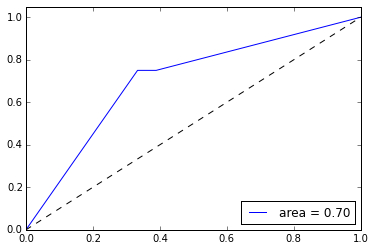

In [25]:
%matplotlib inline
#Create ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

pred_probas = lr.predict_proba(test_vecs)[:,1]

fpr,tpr,_ = roc_curve(y_test, pred_probas)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label='area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')

plt.show()

In [1]:
import os
DATA_DIR = '/home/rt/wrk/w209/yelp/data'
with open(os.path.join(DATA_DIR, 'pos.txt'), 'r') as infile:
    pos_reviews = infile.readlines()[:10]

In [2]:
len(pos_reviews)

10

In [3]:
import gensim
import os

LabeledSentence = gensim.models.doc2vec.LabeledSentence

from sklearn.cross_validation import train_test_split
import numpy as np

with open(os.path.join(DATA_DIR, 'pos.txt'), 'r') as infile:
    pos_reviews = infile.readlines()[:10]

with open(os.path.join(DATA_DIR, 'neg.txt'), 'r') as infile:
    neg_reviews = infile.readlines()[:10]

with open(os.path.join(DATA_DIR, 'unsup.txt'), 'r') as infile:
    unsup_reviews = infile.readlines()[:10]

#use 1 for positive sentiment, 0 for negative
y = np.concatenate((np.ones(len(pos_reviews)), np.zeros(len(neg_reviews))))

x_train, x_test, y_train, y_test = train_test_split(np.concatenate((pos_reviews, neg_reviews)), y, test_size=0.2)

#Do some very minor text preprocessing
def cleanText(corpus):
    punctuation = '".,?!:;(){}[]'
    corpus = [z.lower().replace('\n','') for z in corpus]
    corpus = [z.replace('<br />', ' ') for z in corpus]

    #treat punctuation as individual words
    for c in punctuation:
        corpus = [z.replace(c, ' %s '%c) for z in corpus]
    corpus = [z.split() for z in corpus]
    return corpus

x_train = cleanText(x_train)
x_test = cleanText(x_test)
unsup_reviews = cleanText(unsup_reviews)

#Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
#We do this by using the LabeledSentence method. The format will be "TRAIN_i" or "TEST_i" where "i" is
#a dummy index of the review.
def labelizeReviews(reviews, label_type):
    labelized = []
    for i,v in enumerate(reviews):
        label = '%s_%s'%(label_type,i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

x_train = labelizeReviews(x_train, 'TRAIN')
x_test = labelizeReviews(x_test, 'TEST')
unsup_reviews = labelizeReviews(unsup_reviews, 'UNSUP')

In [4]:
import random

size = 400

#instantiate our DM and DBOW models
model_dm = gensim.models.Doc2Vec(min_count=1, window=10, size=size, sample=1e-3, negative=5, workers=16)
model_dbow = gensim.models.Doc2Vec(min_count=1, window=10, size=size, sample=1e-3, negative=5, dm=0, workers=16)

In [5]:
#build vocab over all reviews
all_words = x_train + x_test + unsup_reviews
model_dm.build_vocab(x_train)
model_dbow.build_vocab(x_train)

In [6]:
all_train_reviews = np.concatenate((x_train, unsup_reviews))

In [ ]:
#We pass through the data set multiple times, shuffling the training reviews each time to improve accuracy.
for epoch in range(1):
    print epoch
    perm = np.random.permutation(all_train_reviews.shape[0])
    print perm
    model_dm.train(all_train_reviews[perm])
    #model_dbow.train(all_train_reviews[perm])

In [ ]:
#Get training set vectors from our models
def getVecs(model, corpus, size):
    vecs = [np.array(model[z.labels[0]]).reshape((1, size)) for z in corpus]
    return np.concatenate(vecs)

In [ ]:
train_vecs_dm = getVecs(model_dm, x_train, size)
train_vecs_dbow = getVecs(model_dbow, x_train, size)

train_vecs = np.hstack((train_vecs_dm, train_vecs_dbow))

#train over test set
x_test = np.array(x_test)

In [ ]:
for epoch in range(10):
    print "iteration: {}".format(epoch)
    perm = np.random.permutation(x_test.shape[0])
    model_dm.train(x_test[perm])
    model_dbow.train(x_test[perm])

In [ ]:
#Construct vectors for test reviews
test_vecs_dm = getVecs(model_dm, x_test, size)
test_vecs_dbow = getVecs(model_dbow, x_test, size)

test_vecs = np.hstack((test_vecs_dm, test_vecs_dbow))

In [ ]:
import random

size = 400

#instantiate our DM and DBOW models
model_dm = gensim.models.Doc2Vec(min_count=1, window=10, size=size, sample=1e-3, negative=5, workers=3)
model_dbow = gensim.models.Doc2Vec(min_count=1, window=10, size=size, sample=1e-3, negative=5, dm=0, workers=3)

#build vocab over all reviews
all_words = x_train + x_test + unsup_reviews
model_dm.build_vocab(x_train)
model_dbow.build_vocab(x_train)

#We pass through the data set multiple times, shuffling the training reviews each time to improve accuracy.
all_train_reviews = np.concatenate((x_train, unsup_reviews))
for epoch in range(10):
    perm = np.random.permutation(all_train_reviews.shape[0])
    model_dm.train(all_train_reviews[perm])
    model_dbow.train(all_train_reviews[perm])

#Get training set vectors from our models
def getVecs(model, corpus, size):
    vecs = [np.array(model[z.labels[0]]).reshape((1, size)) for z in corpus]
    return np.concatenate(vecs)

train_vecs_dm = getVecs(model_dm, x_train, size)
train_vecs_dbow = getVecs(model_dbow, x_train, size)

train_vecs = np.hstack((train_vecs_dm, train_vecs_dbow))

#train over test set
x_test = np.array(x_test)

for epoch in range(10):
    print "iteration: {}".format(epoch)
    perm = np.random.permutation(x_test.shape[0])
    model_dm.train(x_test[perm])
    model_dbow.train(x_test[perm])

#Construct vectors for test reviews
test_vecs_dm = getVecs(model_dm, x_test, size)
test_vecs_dbow = getVecs(model_dbow, x_test, size)

test_vecs = np.hstack((test_vecs_dm, test_vecs_dbow))

In [1]:
import gensim

In [2]:
gensim.__version__

'0.12.3'

In [3]:
import scipy

In [4]:
scipy.__version__

'0.16.1'

In [5]:
gensim.models.doc2vec.FAST_VERSION

1